### Outlier Factors for Device Profiling

TODO

For this first part of the presentation, we will be using data in the form of (timestamp, source computer, number of bytes) where each data point represents a data flow. Data will be binned and so two different features will be extracted per source computer, per bin. That is count of flows and average number of flows per bin.

For testing purposes a generated dataset will be used.

For our initial review time index will not be treated differently between different flows.
For this dataset, 5 different source computers (or users) will be simulated.

In [128]:
#generate data for users
import numpy as np
from random import randint
%matplotlib inline

number_of_hosts = 5
time_limits = [1,10]

flows = []

def create_flow(user, number_of_flows, time_limits, byte_limits):
    for _ in range(number_of_flows):
        time = randint(time_limits[0], time_limits[1])
        byte_count = randint(byte_limits[0], byte_limits[1])
        flows.append([time, user, byte_count])

# users C0 and C1 have a total of 10 flows randomly in the timelimits with a total byte count uniformly selected from [50,200] bytes
create_flow('C' + str(0), 20, time_limits, [50,200])
create_flow('C' + str(1), 20, time_limits, [100,1000])
        
# user C2 initialy has 5 flows with byte count [50,200] and then 5 with byte count [500,1000] and user C3 the reverse
create_flow('C' + str(2), 10, [time_limits[0], int(time_limits[1]/2)], [50,200])
create_flow('C' + str(2), 10, [int(time_limits[1]/2) + 1, time_limits[1]], [500,1000])

create_flow('C' + str(3), 10, [time_limits[0], int(time_limits[1]/2)], [500,1000])
create_flow('C' + str(3), 10, [int(time_limits[1]/2) + 1, time_limits[1]], [50,200])

# user C4 has 5 flows  in [50, 200] and an outliers
create_flow('C' + str(4), 10, [time_limits[0], time_limits[1]], [50,200])
flows.append([7, 'C' + str(4), 5500])
flows.append([7, 'C' + str(4), 9500])
flows.append([7, 'C' + str(4), 5500])


In [129]:
import pandas as pd

df = pd.DataFrame(flows)

In [130]:
# Save data for future work

df.to_csv('../../../diploma/generated_data/flows.txt', header=False, index=False)

From these flows per user, we can generate the features count and average byte count.

Next we will display the in a scatter plot the points generated

In [20]:
import pandas as pd
import numpy as np
%matplotlib inline

number_of_hosts = 5
time_limits = [1,10]

df = pd.read_csv('../../../diploma/generated_data/flows.txt', header=None)

df.columns = ['time', 'source computer', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.sort_index(inplace=True)
df.head()

,source computer,byte count
time,,
1,C0,188
1,C4,70
1,C4,107
1,C3,527
1,C3,537


For better illustration we will plot these points in a two dimensional grid

In the following we plot the for each host the flows per bin and after temporal bins format.

In [21]:
# keep track of the different host TODO

hosts = np.array(list(set(df['source computer'].values)))
hosts.sort()

# Create buckets based on the time of the events, a bucker for every size_of_bin_seconds seconds

size_of_bin_seconds = 1
bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds + 1, size_of_bin_seconds)
print('The borders of the bins created: ', bins)

The borders of the bins created:  [ 1  2  3  4  5  6  7  8  9 10 11]


In this ty example we create a bin for each time index. In the final dataset this will correspond to a bin every second

In [22]:
# group by the correct bin and the source computer

groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

mean_values = groups.mean().values
count_values = groups.count().values

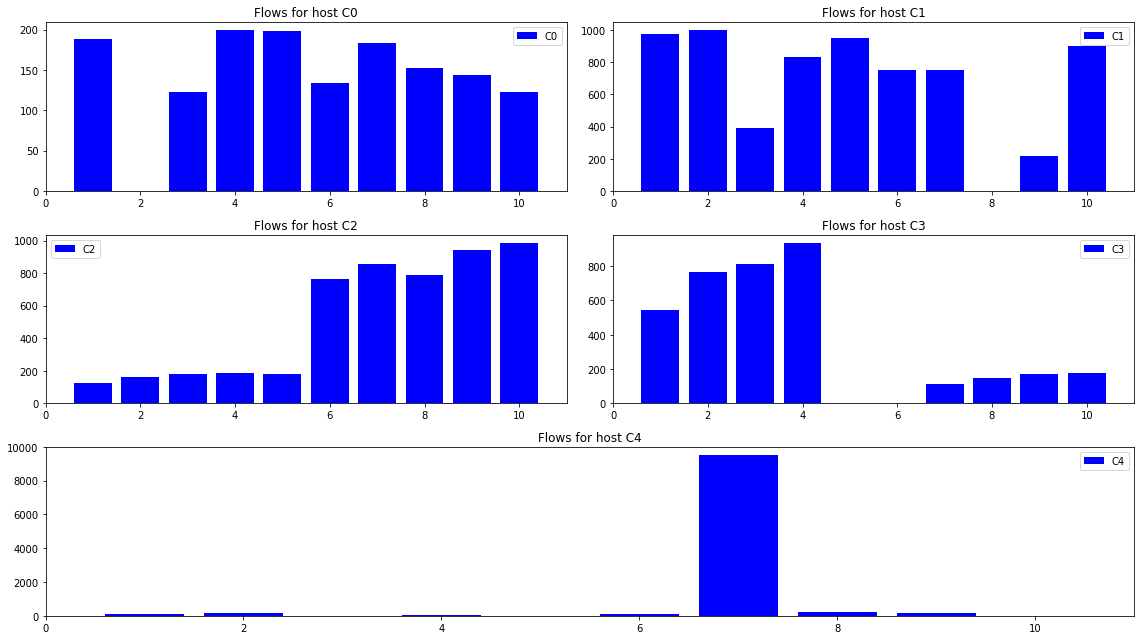

In [23]:
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

for i in range(number_of_hosts):
    if number_of_hosts % 2 == 0:
        plt.subplot(number_of_hosts/2, 2, i + 1)
    else:
        if i < number_of_hosts - 1:
            plt.subplot(int(number_of_hosts/2) + 1, 2, i + 1)
        else:
            plt.subplot(int(number_of_hosts/2) + 1, 1, int(number_of_hosts/2) + 1)

    df_for_host = df[df['source computer'].isin([hosts[i]])]
    plt.bar(df_for_host.index, df_for_host['byte count'], label=hosts[i], color='blue')

    plt.title('Flows for host ' + hosts[i])
    plt.xlim([time_limits[0] - 1, time_limits[1] + 1])
    plt.legend()
    
plt.tight_layout()
plt.show()

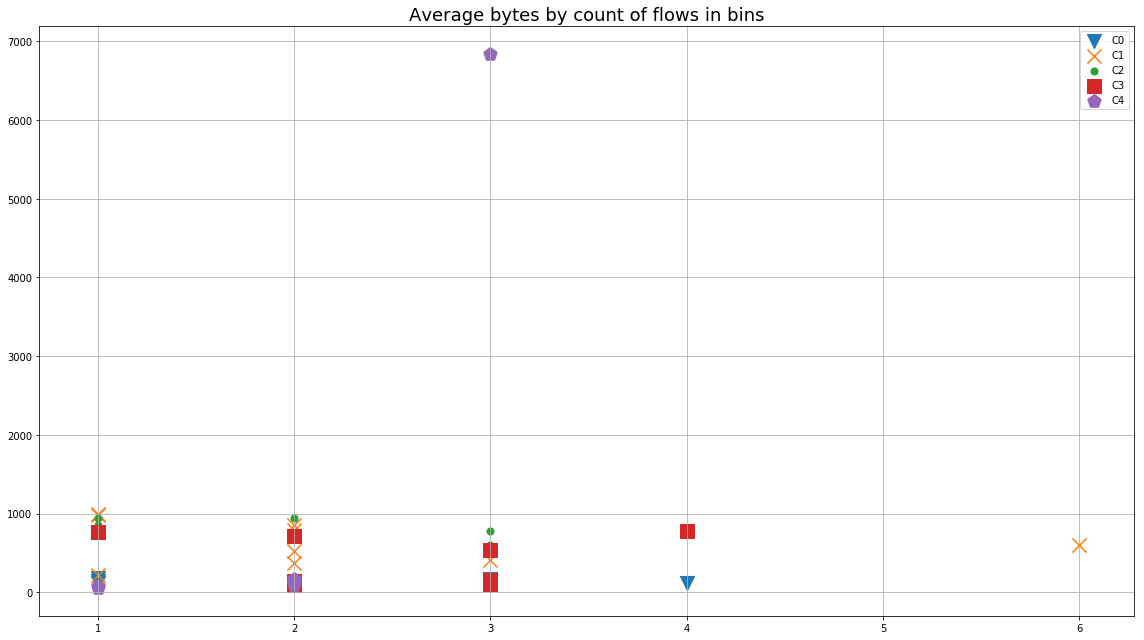

In [24]:
markers = ['v', 'x', '.', 's', 'p']

for i in range(number_of_hosts):
    filter_list = [x for x in groups.apply(lambda x:  (x['source computer'] == hosts[i]).values[0])]
    
    plt.scatter(count_values[filter_list], mean_values[filter_list], s=200, 
                marker=markers[i % len(markers)], label=hosts[i])
    
plt.title('Average bytes by count of flows in bins', fontsize=18)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Global and host - specific means

As a first naive approach we calculate the mean for each individual host and the global mean generated from these meassurements

First we preprocess the data

As all data will have a positive value we could just scale them using a simple approach:

$$log(x + 1)$$

In [25]:
data = groups.count()
data.columns = ['number of flows']
data['mean(byte count)'] = groups.mean().values

data.head()

number of flows  mean(byte count)
  source computer                                   
1 C0                             3        160.333333
  C1                             1        977.000000
  C2                             1        125.000000
  C3                             3        536.333333
  C4                             2         88.500000

In [26]:
def scale(x):
    return np.log(x + 1)

In [27]:
data_by_host = {}

for host in hosts:
    for i in range(len(bins) - 1):
        try:
            values = scale(data.loc[(i + 1, host)].values)
        except:
            values = scale(np.array([0, 0]))
        if i == 0:
            data_by_host[host] = np.array([values])
        else:
            data_by_host[host] = np.append(data_by_host[host], np.array([values]), axis=0)

Perhaps the log function will "hide" potential outliers and will not be a good match for the metric distance used later.
Instead we will use a standard 

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# to all data append [0, 0] so that [0, 0] is the mapped to [0, 0] with our new scaler
scaler.fit(np.append(data.values, np.array([[0, 0]]), axis=0))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
data_by_host = {}

for host in hosts:
    for i in range(len(bins) - 1):
        try:
            values = scaler.transform([data.loc[(i + 1, host)].values])
        except:
            values = scaler.transform([np.array([0, 0])])
        if i == 0:
            data_by_host[host] = np.array(values)
        else:
            data_by_host[host] = np.append(data_by_host[host], np.array(values), axis=0)

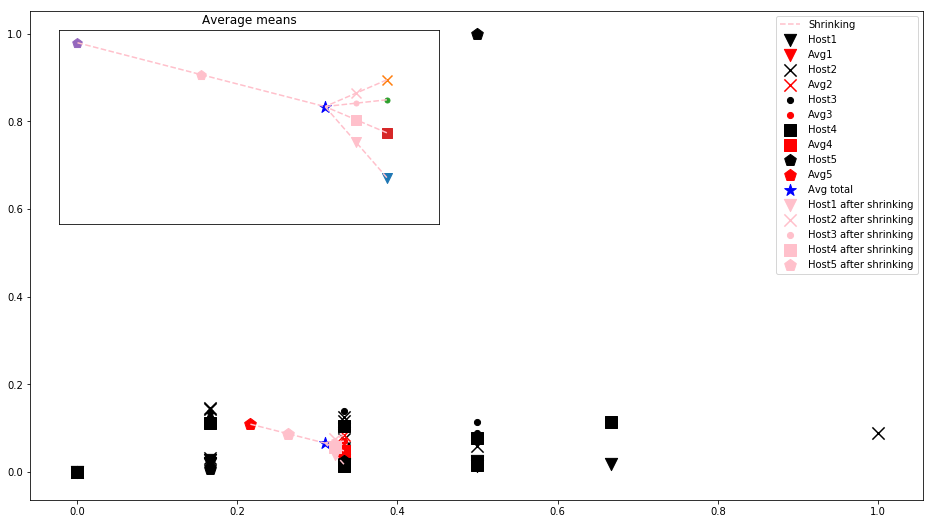

In [30]:
# the shrinkage
shrinkage = 0.5

i = 0
means = []
for host, data_for_host in data_by_host.items():
    # two features used
    x = data_for_host[:,0]
    y = data_for_host[:,1]
    plt.scatter(x, y, marker=markers[i % len(markers)], s=150, color='black', label='Host' + str(i + 1))
    mean_x = sum(x)/len(x)
    mean_y = sum(y)/len(y)
    means.append([mean_x, mean_y])
    
    plt.scatter(mean_x, mean_y, marker=markers[i % len(markers)], s=150, color='red', label='Avg' + str(i + 1))
    i += 1
    if i == number_of_hosts:
        break

global_mean = [float(sum(col))/len(col) for col in zip(*means)]

plt.scatter(global_mean[0], global_mean[1], marker='*', s=150, color='blue', label='Avg total')

i = 0
for mean in means:
    if i == 0:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', label='Shrinking', color='pink')
    else:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', color='pink')
    i += 1

i = 0
for mean in means:
    shrinked = np.array(mean) * (1 - shrinkage) + np.array(global_mean) * shrinkage
    plt.scatter(shrinked[0], shrinked[1], marker=markers[i % len(markers)], s=150, color='pink', label='Host' + str(i + 1) + ' after shrinking')
    i += 1

plt.legend()


# this is an inset axes over the main axes
plt.axes([.15, .55, .33, .3])
for i, mean in enumerate(means):
    plt.scatter(mean[0], mean[1], marker=markers[i % len(markers)], s=100)
    plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', color='pink')
    
    shrinked = np.array(mean) * (1 - shrinkage) + np.array(global_mean) * shrinkage
    plt.scatter(shrinked[0], shrinked[1], marker=markers[i % len(markers)], color='pink', s=100)
    
plt.scatter(global_mean[0], global_mean[1], marker='*', s=150, color='blue')

plt.title('Average means')
plt.xticks([])
plt.yticks([])


plt.show()

First we will attempt a naive clustering of these points

In [31]:
import itertools

all_data = list(itertools.chain(*list(data_by_host.values())))

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(all_data)

print(kmeans.cluster_centers_)

[[ 0.10526316  0.04211553]
 [ 0.43548387  0.08067899]]


A possible error that can occur is if the number of clusters in high and anomalies are similar, clusters may be formed around the anomalies.

This can probably be accpted

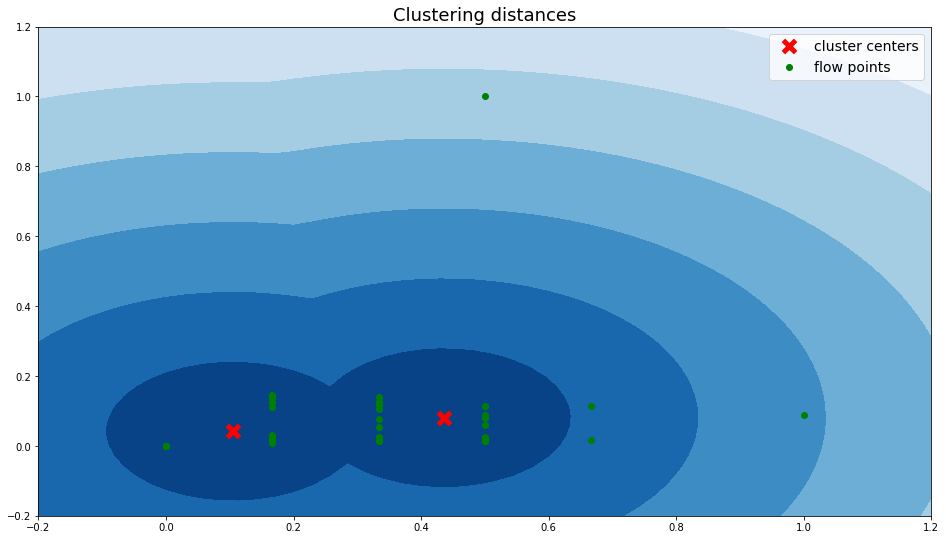

In [33]:
def distance_to_closest_cluster(X, kmeans):
    distances = kmeans.transform(X)
    return np.min(distances, axis=1)

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 50), np.linspace(-0.2, 1.2, 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = distance_to_closest_cluster(np.c_[xx.ravel(), yy.ravel()], kmeans)
Z = Z.reshape(xx.shape)

plt.title("Clustering distances", fontsize=18)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

for center in kmeans.cluster_centers_:
    a = plt.scatter(center[0], center[1], color='red', marker='x', s=150, linewidth=5)
    
for point in all_data:
    b = plt.scatter(point[0], point[1], color='green', marker='o') 

plt.axis('tight')
plt.xlim(-0.2,1.2)
plt.ylim(-0.2,1.2)
plt.legend([a, b], ["cluster centers","flow points"], fontsize=14)
plt.show()

For the rest of this excercise we will be using the dataset provided at https://csr.lanl.gov/data/cyber1/ 

From the file flows.txt the first 100,000 lines will be initially used

In [34]:
N = 20000

df_N = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=100000)

In [35]:
df_N.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_N.index = df_N['time']
df_N.drop(columns=['time'],inplace=True)
df_N.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [40]:
from sklearn.preprocessing import MinMaxScaler

def get_data_by_dataframe(df, size_of_bin_seconds=50):
    """
    :param size_of_bin_seconds: the time period of each bin,
                assumes the dataframe has a column names 'source computer' and a name 'byte count'
    :return: a dictionary containing for each host the features, the hosts 
    """
    hosts = np.array(list(set(df['source computer'].values)))
    
    bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds + 1, size_of_bin_seconds)
    
    groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

    data = groups.count()
    data.columns = ['number of flows']
    data['mean(byte count)'] = groups.mean().values
    
    scaler = MinMaxScaler()
    
    # to all data append [0, 0] so that [0, 0] is the mapped to [0, 0] with our new scaler
    scaler.fit(np.append(data.values, np.array([[0, 0]]), axis=0))
    
    data_by_host = {}
     
    for host in hosts:
        for i in range(len(bins) - 1):
            try:
                values = scaler.transform([data.loc[(i + 1, host)].values])
            except:
                values = scaler.transform([np.array([0, 0])])
            if i == 0:
                data_by_host[host] = np.array(values)
            else:
                data_by_host[host] = np.append(data_by_host[host], np.array(values), axis=0)
                
    return data_by_host, hosts

data_by_host_N, hosts_N = get_data_by_dataframe(df_N)

For completeness display the two dimensional space created in this real dataset

[[  4.66933345e-04   1.68882257e-04]
 [  4.75772215e-03   5.66899773e-01]
 [  5.44701675e-01   5.68643147e-06]]


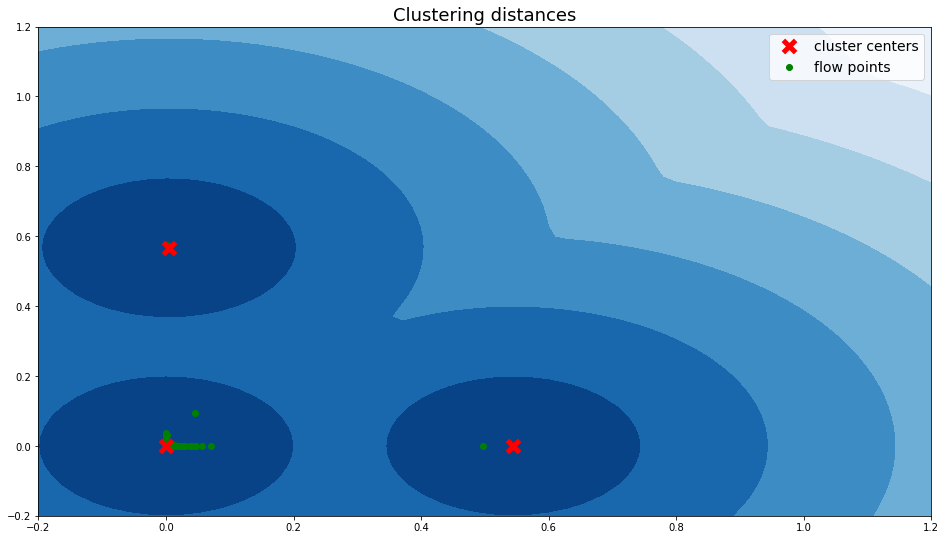

In [43]:
import itertools
from sklearn.cluster import KMeans

all_data_N = list(itertools.chain(*list(data_by_host_N.values())))

kmeans_N = KMeans(n_clusters=3, random_state=0).fit(all_data_N)

print(kmeans_N.cluster_centers_)

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 50), np.linspace(-0.2, 1.2, 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = distance_to_closest_cluster(np.c_[xx.ravel(), yy.ravel()], kmeans_N)
Z = Z.reshape(xx.shape)

plt.title("Clustering distances", fontsize=18)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)


# randomly scatter some only points
choices = np.random.choice(len(all_data_N), 5000)

for choice in choices:
    point = all_data_N[choice]
    b = plt.scatter(point[0], point[1], color='green', marker='o') 

for center in kmeans_N.cluster_centers_:
    a = plt.scatter(center[0], center[1], color='red', marker='x', s=150, linewidth=5)
        
plt.axis('tight')
plt.xlim(-0.2,1.2)
plt.ylim(-0.2,1.2)
plt.legend([a, b], ["cluster centers","flow points"], fontsize=14)
plt.show()